In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings("ignore")

import datasets as ds
import matplotlib.pyplot as plt
import numpy as np
import optimization as opt
import sklearn.datasets as skds
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import robust_scale


In [3]:
def _test_opt(Xs, ys, coefs):
    """Test optimization methods and record their MSE, elapsed time, and loss."""

    mse_dict, elapsed_dict, loss_dict = {}, {}, {}
    for key in Xs.keys():

        X = torch.tensor(Xs[key], dtype=torch.float32)
        y = torch.tensor(ys[key], dtype=torch.float32)
        coef = torch.tensor(coefs[key])

        method = "sgd"
        coef_, loss, elapsed = opt.train_model(X, y, method=method, n_epochs=250)
        mse_dict[f"{method}-{key}"] = float((coef - coef_).mean())
        elapsed_dict[f"{method}-{key}"] = elapsed
        loss_dict[f"{method}-{key}"] = loss

        method = "newton"
        coef_, loss, elapsed = opt.train_model(X, y, method=method, n_epochs=250)
        mse_dict[f"{method}-{key}"] = float((coef - coef_).mean())
        elapsed_dict[f"{method}-{key}"] = elapsed
        loss_dict[f"{method}-{key}"] = loss

        method = "lbfgs"
        coef_, loss, elapsed = opt.train_model(X, y, method=method, n_epochs=250)
        mse_dict[f"{method}-{key}"] = float((coef - coef_).mean())
        elapsed_dict[f"{method}-{key}"] = elapsed
        loss_dict[f"{method}-{key}"] = loss

    return mse_dict, elapsed_dict, loss_dict


### simulate datasets for linear least squares

In [4]:
Xs_noise, ys_noise, coefs_noise = ds.generate_datasets(
    "noise", linear=True, noise=[0, 10, 100]
)

Xs_n_samples, ys_n_samples, coefs_n_samples = ds.generate_datasets(
    "n_samples", linear=True, n_samples=[500, 1000, 10000]
)

Xs_n_features, ys_n_features, coefs_n_features = ds.generate_datasets(
    "n_features", linear=True, n_features=[3, 5, 200]
)


>>> noise


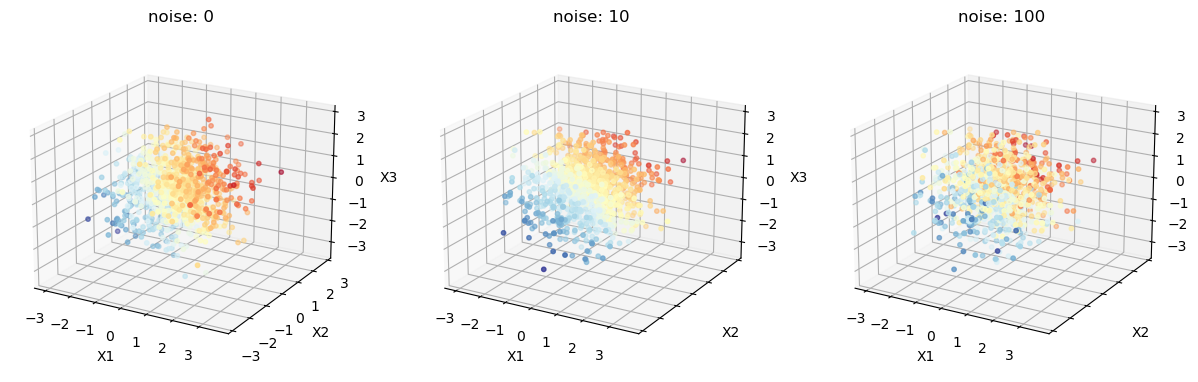

>>> n_samples


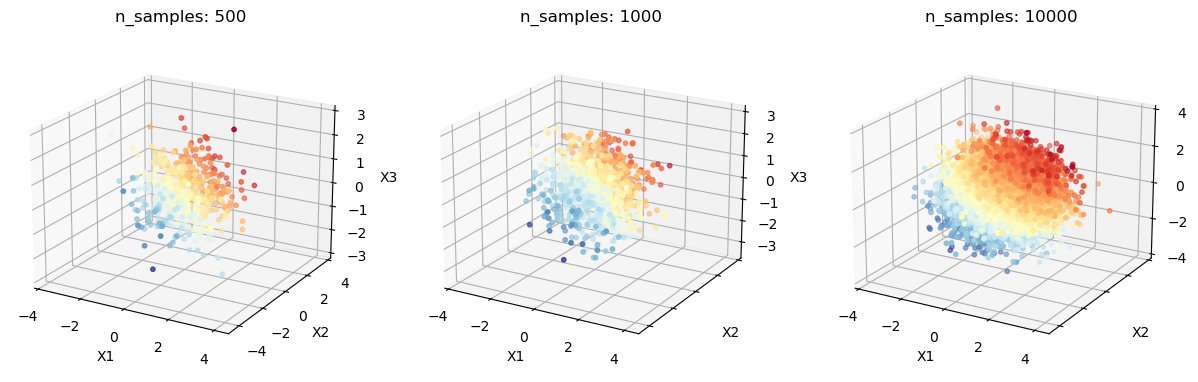

>>> n_features


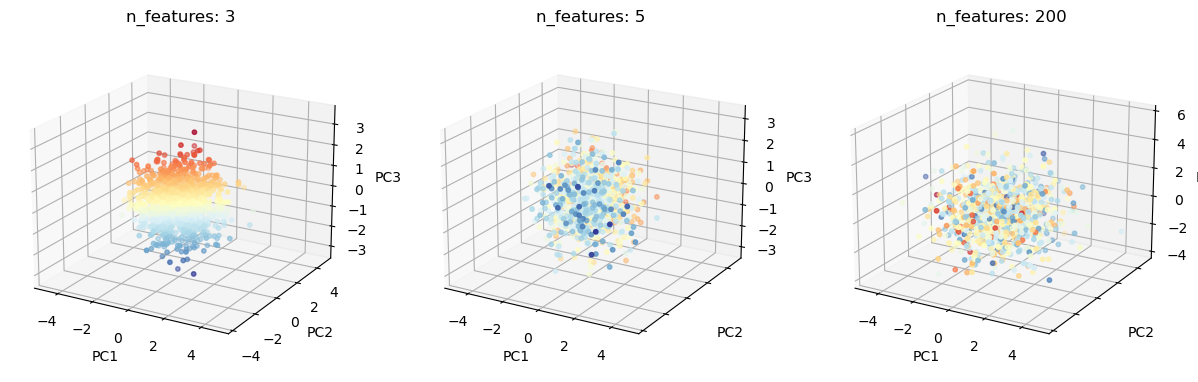

In [5]:
print(">>> noise")
ds.plot_3d_projection("noise", Xs_noise, ys_noise)
plt.show()

print(">>> n_samples")
ds.plot_3d_projection("n_samples", Xs_n_samples, ys_n_samples)
plt.show()

print(">>> n_features")
ds.plot_3d_projection("n_features", Xs_n_features, ys_n_features)
plt.show()


In [ ]:
# !!! ~10 minutes to run

print(">>> noise")
mse_noise, elapsed_noise, loss_noise = _test_opt(Xs_noise, ys_noise, coefs_noise)

print(">>> n_samples")
mse_n_samples, elapsed_n_samples, loss_n_samples = _test_opt(
    Xs_n_samples, ys_n_samples, coefs_n_samples
)

print(">>> n_features")
mse_n_features, elapsed_n_features, loss_n_features = _test_opt(
    Xs_n_features, ys_n_features, coefs_n_features
)


### simulate datasets for non-linear least squares

In [6]:
Xs_noise, ys_noise, _ = ds.generate_datasets("noise", linear=False, noise=[0, 50, 100])
Xs_n_samples, ys_n_samples, _ = ds.generate_datasets(
    "n_samples", linear=False, n_samples=[500, 1000, 10000]
)


>>> noise


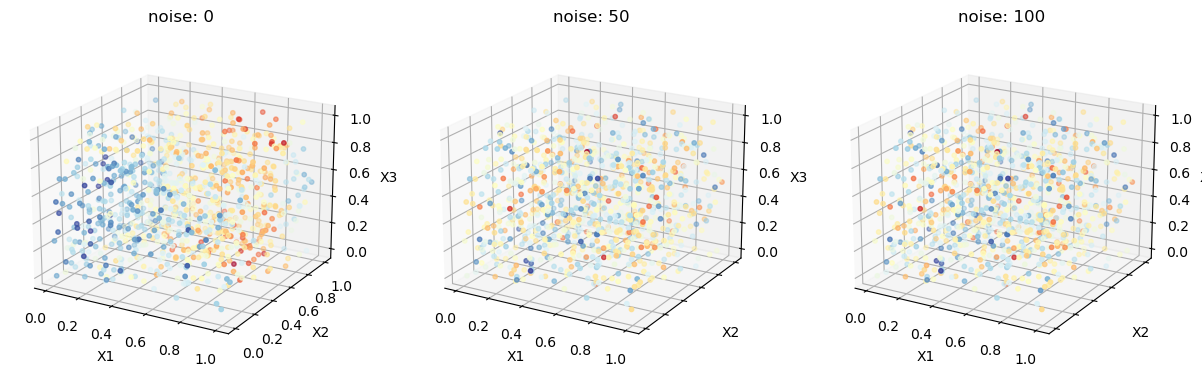

>>> n_samples


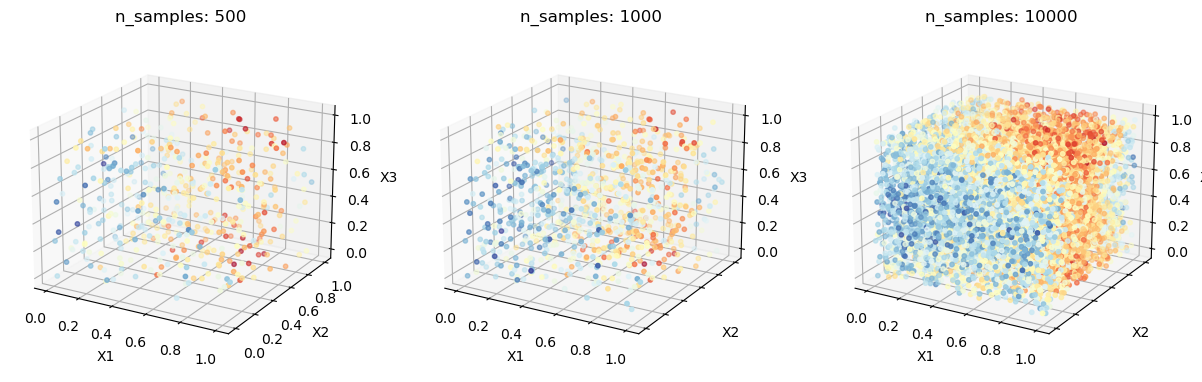

In [7]:
print(">>> noise")
ds.plot_3d_projection("noise", Xs_noise, ys_noise)
plt.show()

print(">>> n_samples")
ds.plot_3d_projection("n_samples", Xs_n_samples, ys_n_samples)
plt.show()


### dataset examples

In [8]:
def _test_opt_datasets(X, y, method=None):
    """Test optimization methods and record their MSE, elapsed time, and loss."""

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=0
    )

    if method == "lstsq":
        coef_ = opt.normal_eq_lr(X_train, y_train)
        mse = float((y_test - X_test @ coef_).mean())
        print(f">>> {method}\nMSE = {mse:.3f}\n")
    else:
        coef_, loss, elapsed = opt.train_model(
            X_train, y_train, method=method, n_epochs=250
        )
        mse = float((y_test - X_test @ coef_).mean())
        print(f">>> {method}\nMSE = {mse:.3f} (elapsed time = {elapsed:.3f} s)\n")
        return np.sqrt(loss)


In [9]:
db = skds.load_diabetes(as_frame=True, scaled=True)
db_X, db_y = db.data, db.target
print("X =", *db_X.columns, "\n(n_samples, n_features) =", db_X.shape)


X = age sex bmi bp s1 s2 s3 s4 s5 s6 
(n_samples, n_features) = (442, 10)


Text(0.5, 0, 'Ys')

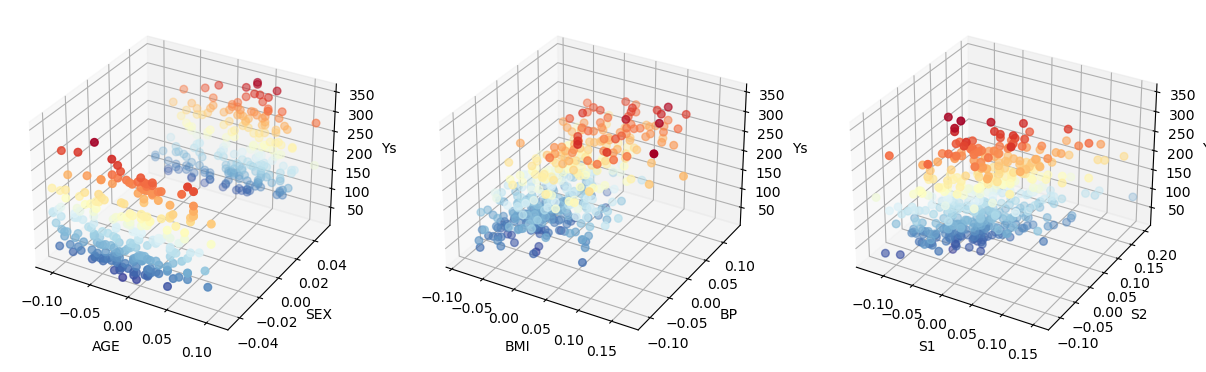

In [10]:
# marginal plots
fig, axs = plt.subplots(1, 3, figsize=(15, 10), subplot_kw=dict(projection="3d"))

cmap = "RdYlBu_r"
axs[0].scatter(db_X["age"], db_X["sex"], db_y, c=db_y, s=30, cmap=cmap)
axs[0].set_xlabel("AGE")
axs[0].set_ylabel("SEX")
axs[0].set_zlabel("Ys")

axs[1].scatter(db_X["bmi"], db_X["bp"], db_y, c=db_y, s=30, cmap=cmap)
axs[1].set_xlabel("BMI")
axs[1].set_ylabel("BP")
axs[1].set_zlabel("Ys")

ax = axs[2].scatter(db_X["s1"], db_X["s2"], db_y, c=db_y, s=30, cmap=cmap)
axs[2].set_xlabel("S1")
axs[2].set_ylabel("S2")
axs[2].set_zlabel("Ys")


In [11]:
X = torch.tensor(db_X.values, dtype=torch.float32)
y = torch.tensor(db_y.values, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

method = "lstsq"
coef_ = _test_opt_datasets(X_train, y_train, method=method)

method = "sgd"
sgd_loss = _test_opt_datasets(X_train, y_train, method=method)

method = "newton"
newton_loss = _test_opt_datasets(X_train, y_train, method=method)

method = "lbfgs"
lbfgs_loss = _test_opt_datasets(X_train, y_train, method=method)


>>> lstsq
MSE = 166.001

>>> sgd
MSE = 168.945 (elapsed time = 0.095 s)

>>> newton
MSE = 178.506 (elapsed time = 0.709 s)

>>> lbfgs
MSE = 178.502 (elapsed time = 1.619 s)



Text(0.5, 1.0, 'LBFGS')

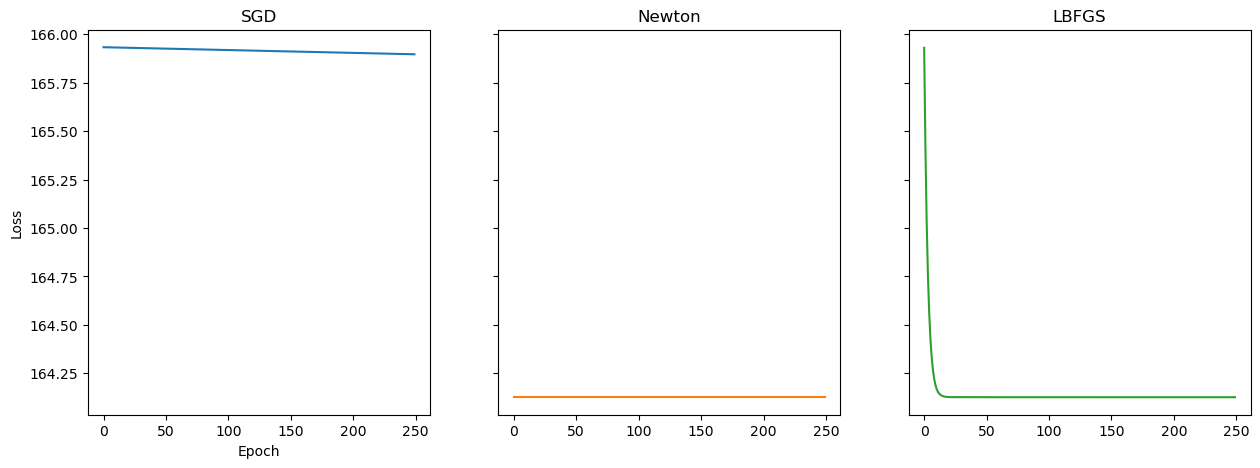

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

axs[0].plot(sgd_loss, label="SGD", c="C0")
axs[0].set_title("SGD")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")

axs[1].plot(newton_loss, label="Newton", c="C1")
axs[1].set_title("Newton")

axs[2].plot(lbfgs_loss, label="LBFGS", c="C2")
axs[2].set_title("LBFGS")


In [13]:
cal = skds.fetch_california_housing(as_frame=True)
cal_df = cal.frame.drop(columns=["Latitude", "Longitude"]).apply(robust_scale)
print("X =", *cal_df.columns[:-1], "\n(n_samples, n_features) =", cal_df.shape)


X = MedInc HouseAge AveRooms AveBedrms Population AveOccup 
(n_samples, n_features) = (20640, 7)


Text(0.5, 0, 'MedHouseVal')

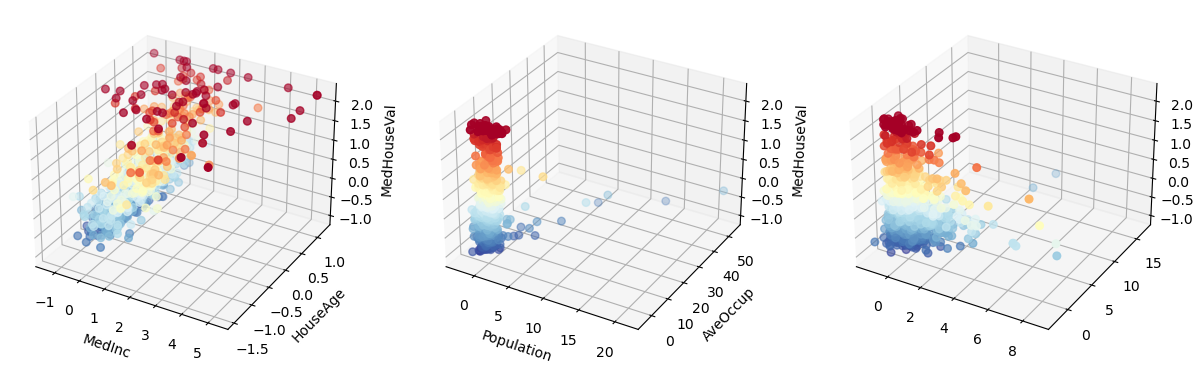

In [14]:
# marginal plots
fig, axs = plt.subplots(1, 3, figsize=(15, 10), subplot_kw=dict(projection="3d"))

sample = cal_df.sample(1000)

axs[0].scatter(
    sample["MedInc"],
    sample["HouseAge"],
    sample["MedHouseVal"],
    c=sample["MedHouseVal"],
    s=30,
    cmap=cmap,
)
axs[0].set_xlabel("MedInc")
axs[0].set_ylabel("HouseAge")
axs[0].set_zlabel("MedHouseVal")

axs[1].scatter(
    sample["AveRooms"],
    sample["AveBedrms"],
    sample["MedHouseVal"],
    c=sample["MedHouseVal"],
    s=30,
    cmap=cmap,
)
axs[1].set_xlabel("AveRooms")
axs[1].set_ylabel("AveBedrms")
axs[1].set_zlabel("MedHouseVal")

axs[2].scatter(
    sample["Population"],
    sample["AveOccup"],
    sample["MedHouseVal"],
    c=sample["MedHouseVal"],
    s=30,
    cmap=cmap,
)
axs[1].set_xlabel("Population")
axs[1].set_ylabel("AveOccup")
axs[1].set_zlabel("MedHouseVal")


In [15]:
X = torch.tensor(cal_df.iloc[:,:-1].values, dtype=torch.float32)
y = torch.tensor(cal_df.iloc[:,-1], dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

method = "lstsq"
coef_ = _test_opt_datasets(X_train, y_train, method=method)

method = "sgd"
sgd_loss = _test_opt_datasets(X_train, y_train, method=method)

method = "newton"
newton_loss = _test_opt_datasets(X_train, y_train, method=method)

method = "lbfgs"
lbfgs_loss = _test_opt_datasets(X_train, y_train, method=method)

>>> lstsq
MSE = 0.051

>>> sgd
MSE = 0.159 (elapsed time = 69.567 s)

>>> newton
MSE = 0.156 (elapsed time = 560.798 s)

>>> lbfgs
MSE = 0.156 (elapsed time = 318.592 s)



Text(0.5, 1.0, 'LBFGS')

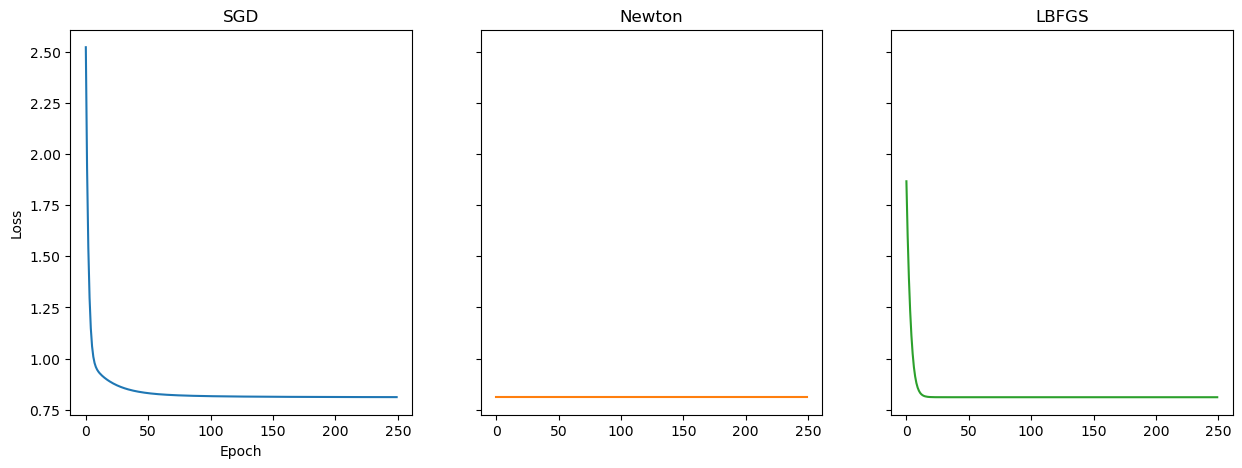

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

axs[0].plot(sgd_loss, label="SGD", c="C0")
axs[0].set_title("SGD")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")

axs[1].plot(newton_loss, label="Newton", c="C1")
axs[1].set_title("Newton")

axs[2].plot(lbfgs_loss, label="LBFGS", c="C2")
axs[2].set_title("LBFGS")
